In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random

### This is example 1 for the paper - a 4 comm SBM with 1000 nodes

#### once all introduced, you need to scroll to the bottom, where I make many samples from the model, and one bootstrap for each, and test to see how good it is, that's what goes in the paper

In [2]:
# Network generation --------------------------------------------------------
random.seed(10)
np.random.seed(10)

n = 1000  # number of nodes
K = 4   # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []
# B_list.append(np.array([[0.55, 0.4, 0.4, 0.5, 0.3], 
#                         [0.4, 0.2, 0.3, 0.5, 0.6], 
#                         [0.5, 0.3, 0.6, 0.4, 0.7], 
#                         [0.4, 0.1, 0.2, 0.3, 0.2], 
#                         [0.6, 0.3, 0.5, 0.6, 0.7]]))

B_list.append(np.array([[0.8, 0.1, 0.5, 0.3],
                        [0.4, 0.6, 0.9, 0.2],
                        [0.7, 0.2, 0.4, 0.8],
                        [0.3, 0.5, 0.6, 0.1]]))

In [3]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [4]:
random.seed(100)
np.random.seed(100)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
A_t = np.random.binomial(n=1, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

As = As.astype(int)
P = np.column_stack(P_list)

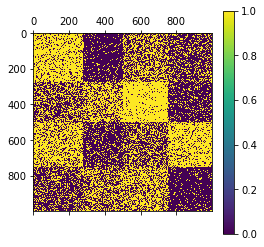

In [5]:
# Sample drawn using the above P in a Bern(P) - this is the Observed A matrix
cax = plt.matshow(As)
plt.colorbar(cax)
plt.show()

In [6]:
d=4
# as rank(P) = 4

In [7]:
ya = UASE([As.astype(float)], d)
plot_embedding(ya, n, 1, tau)

In [8]:
title="4 Community SBM with n=1000 nodes embedded with UASE into d=2 dimensions"
T=1

yadf = pd.DataFrame(ya[:, 0:2])
yadf.columns = ["Dimension {}".format(i + 1) for i in range(yadf.shape[1])]
yadf["Time"] = np.repeat([t for t in range(T)], n)
yadf["Community"] = list(tau) 
yadf["Community"] = yadf["Community"].astype(str)
pad_x = (max(ya[:, 0]) - min(ya[:, 0])) / 50
pad_y = (max(ya[:, 1]) - min(ya[:, 1])) / 50
fig = px.scatter(
    yadf,
    x="Dimension 1",
    y="Dimension 2",
    color="Community",
    animation_frame="Time",
    range_x=[min(ya[:, 0]) - pad_x, max(ya[:, 0]) + pad_x],
    range_y=[min(ya[:, 1]) - pad_y, max(ya[:, 1]) + pad_y])

# fig.update_layout(title=title, title_font_size=14)
fig.update_traces(marker=dict(size=5))  # Adjust the size as desired
fig.update_layout(
    width=600,  # Adjust width as desired
    height=300,  # Adjust height as desired
)

fig.write_image("4_Community_SBM_n1000_UASE_d2.png")

fig.show()

[43279:0507/164021.144991:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


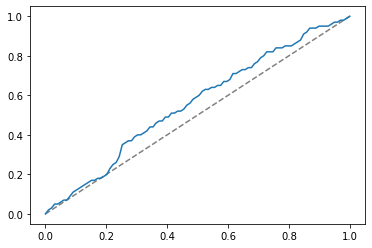

0.06

In [9]:
random.seed(10)
np.random.seed(10)

A_obs = As.astype(float)
p_vals, A_boots = test_bootstrap(A_obs, K, B=100,n_neighbors=5)
A_est = A_boots[0]

plot_power(p_vals, plot=True)

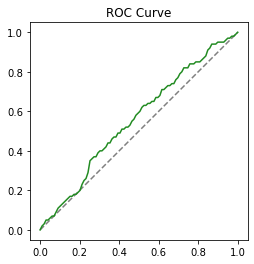

In [10]:
random.seed(10)
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve")
plt.gca().set_aspect('equal', adjustable='box')

# plt.savefig("4_Community_SBM_n1000_UASE_d2_curve.png")

plt.show()

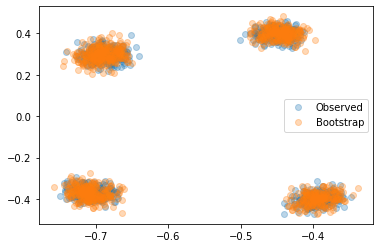

In [11]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=0.3)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=0.3)

plt.legend()

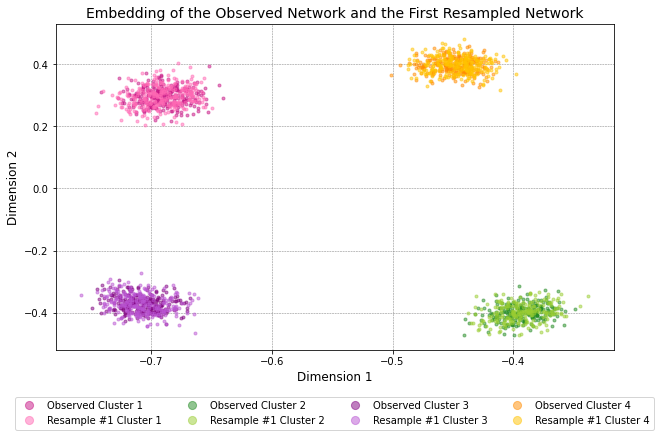

In [37]:
from matplotlib.colors import ListedColormap
cmap = plt.cm.get_cmap('Set2', K)  
cmap2 = plt.cm.get_cmap('Pastel2', K+1)  

# Define custom colors for the colormap
custom_colors = ['#C71585', '#228B22', '#800080', '#FF8C00']  # Example colors, you can adjust these
custom_colors2 = ['#FF69B4', '#9ACD32', '#BA55D3', '#FFC300']  

# Create a custom colormap using ListedColormap
custom_cmap = ListedColormap(custom_colors)
custom_cmap2 = ListedColormap(custom_colors2)

# Set the figure size
plt.figure(figsize=(10, 6))

# Now you can use custom_cmap in your plot
for i, label in enumerate(set(tau)):
    indices = [idx for idx, value in enumerate(tau) if value == label]
    plt.plot(yhat_est[0, indices, 0], yhat_est[0, indices, 1], 'o', alpha=0.5, label=f"Observed Cluster {label+1}", color=custom_cmap(i), markersize=3)
    plt.plot(yhat_est[1, indices, 0], yhat_est[1, indices, 1], 'o', alpha=0.5, label=f"Resample #1 Cluster {label+1}", color=custom_cmap2(i),markersize=3)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.26), markerscale=2.7)

plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)

plt.title("Embedding of the Observed Network and the First Resampled Network", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add gridlines

plt.savefig("4_Community_SBM_n1000_UASE_d2_obs_resample1.png")

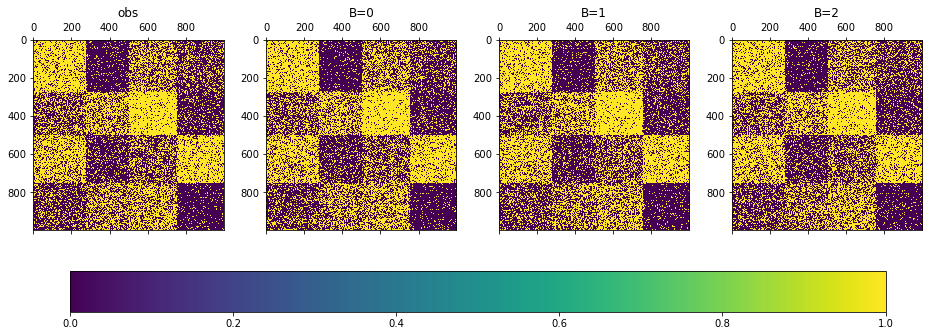

In [13]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

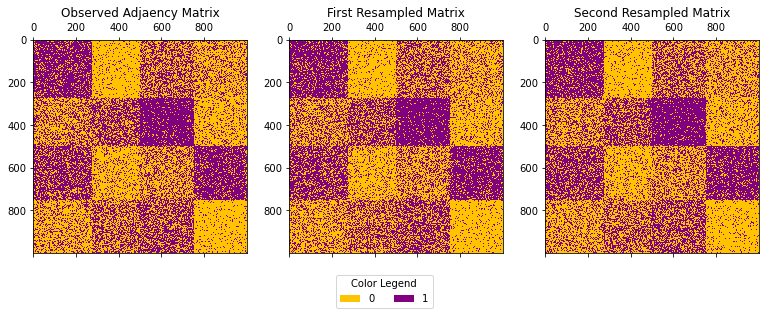

In [14]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Define custom colors for the colormap
legend_colors = ['#FFC300', '#800080']  # Example colors
legend_labels = ['0', '1']  # Labels for colors

# Create a custom colormap using ListedColormap
legend_cmap = ListedColormap(legend_colors)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 5))

# True replicates 
ax0.set_title('Observed Adjaency Matrix')
ax0.matshow(A_obs, cmap=legend_cmap)
ax1.set_title('First Resampled Matrix')
ax1.matshow(A_boots[0], cmap=legend_cmap)
ax2.set_title('Second Resampled Matrix')
ax2.matshow(A_boots[1], cmap=legend_cmap)

# Add color legend manually
legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(legend_colors, legend_labels)]
fig.legend(handles=legend_elements, loc='lower center', title='Color Legend', ncol=len(legend_elements), bbox_to_anchor=(0.5, 0.04))

fig.savefig("4_Community_SBM_n1000_UASE_d2_heatmaps.png")

### Use the test with samples drawn from the same distribution - compared to one bootstrap from itself each time

In [20]:
# Generate more samples from the same model with the same parameters (P matrix)
random.seed(100)

M=200
A_true_draws = []

for m in range(M):
    # Generate random graph from the P matrix
    A_t = np.random.binomial(n=1, p=P_t)
    # turn to integer from float
    A_t = A_t.astype(float)
    As = A_t

    As = As.astype(float)

    A_true_draws.append(As)

In [28]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
p_vals = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=5)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

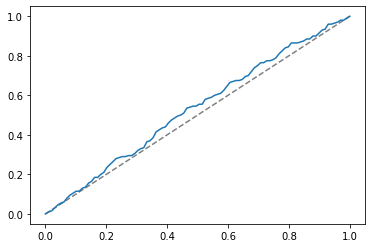

0.055

In [22]:
plot_power(p_vals, plot=True)

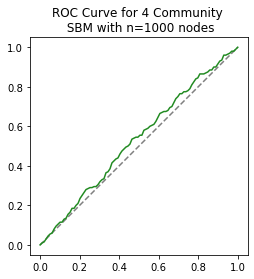

In [25]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4_Community_SBM_n1000_M2000_Q1000_UASE_d4_curve.png")

plt.show()

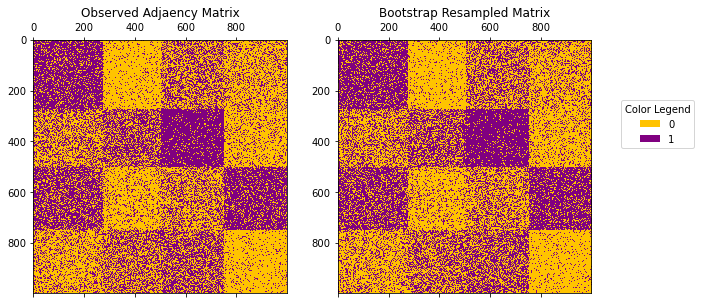

In [33]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Define custom colors for the colormap
legend_colors = ['#FFC300', '#800080']  # Example colors
legend_labels = ['0', '1']  # Labels for colors

# Create a custom colormap using ListedColormap
legend_cmap = ListedColormap(legend_colors)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# True replicates 
ax0.set_title('Observed Adjaency Matrix')
ax0.matshow(A_true_draws[0], cmap=legend_cmap)
ax1.set_title('Bootstrap Resampled Matrix')
ax1.matshow(A_boots_list[0], cmap=legend_cmap)

# Add color legend manually
legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(legend_colors, legend_labels)]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 0.7), title='Color Legend')

fig.savefig("4_Community_SBM_n1000_M2000_Q1000_UASE_d4_heatmaps_firstObsAndBoots.png")

### Try and do some variance estimation